In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
from unicodedata import normalize
import json
import re
import regex
import requests
import ast

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/lorenzovaralo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
con = sqlite3.connect('database')
curr = con.cursor()

In [3]:
df = pd.read_sql('SELECT * FROM CarInfoRaw;', con, index_col='Id')

In [4]:
fipe = pd.read_sql('SELECT * FROM fipe;', con)

In [5]:
df.isna().sum().sort_values(ascending=False)

financial       8226
dono            5138
exchange        3689
cartype         2632
end_tag         2615
                ... 
subCategory        0
mainCategory       0
price              0
adDate             0
pro_vendor         0
Length: 33, dtype: int64

In [6]:
redundant_data = df.nunique().loc[df.nunique()==1].index
redundant_data

Index(['mainCategory', 'subCategory', 'mainCategoryID', 'subCategoryID', 'estado', 'category'], dtype='object')

In [7]:
df = df.drop(redundant_data, axis='columns')
df.columns

Index(['listId', 'sellerName', 'adDate', 'price', 'ddd', 'brand', 'model', 'versao', 'gearbox', 'titulo', 'region', 'vehicle_model', 'cartype', 'regdate', 'mileage', 'motorpower', 'fuel', 'car_steering', 'carcolor', 'doors', 'end_tag', 'dono', 'exchange', 'financial', 'extra', 'addesc', 'pro_vendor'], dtype='object')

In [8]:
#Colunas com mais de 20% Nulas
null_cols = df.isna().sum()[df.isna().sum() > df.__len__()*0.2]
null_cols

dono         5138
exchange     3689
financial    8226
dtype: int64

In [9]:
df = df.drop(null_cols.index, axis='columns')
df.columns

Index(['listId', 'sellerName', 'adDate', 'price', 'ddd', 'brand', 'model', 'versao', 'gearbox', 'titulo', 'region', 'vehicle_model', 'cartype', 'regdate', 'mileage', 'motorpower', 'fuel', 'car_steering', 'carcolor', 'doors', 'end_tag', 'extra', 'addesc', 'pro_vendor'], dtype='object')

In [10]:
print('Marca None:', df.brand.isna().sum())
print('Modelo None:', df.model.isna().sum())
print('Versao None:', df.versao.isna().sum())
print('VehicleModel None:', (df.vehicle_model == ' ').sum())

Marca None: 74
Modelo None: 161
Versao None: 960
VehicleModel None: 74


In [11]:
df['vehicle_model'].values[df.brand.isna()]

array([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '], dtype=object)

In [12]:
df['vehicle_model'].values[df.versao.isna()]

array(['HONDA CIVIC', 'VW - VOLKSWAGEN GOLF', 'CITROEN C4',
       'FORD TERRITORY', 'TOYOTA COROLLA', 'JEEP COMPASS', 'PEUGEOT 2008',
       'PEUGEOT 2008', 'FORD KA', 'CADILLAC ', 'HYUNDAI ',
       'VW - VOLKSWAGEN ', 'FIAT ', 'VW - VOLKSWAGEN VIRTUS',
       'GM - CHEVROLET BLAZER', 'MITSUBISHI OUTLANDER',
       'VW - VOLKSWAGEN POLO', 'FORD FIESTA', 'TOYOTA YARIS',
       'TOYOTA COROLLA', 'CHERY ', 'GM - CHEVROLET CLASSIC', 'FIAT TORO',
       'FORD PAMPA', 'FORD CLUB', 'RENAULT DUSTER', 'FIAT SIENA',
       'VW - VOLKSWAGEN POLO', 'JEEP COMPASS', 'GM - CHEVROLET SS10',
       'FORD CORCEL', 'GM - CHEVROLET CAMARO', 'CITROEN AIRCROSS',
       'JEEP COMPASS', 'GM - CHEVROLET ONIX', 'TOYOTA YARIS', 'LIFAN X60',
       'JEEP COMMANDER', 'VW - VOLKSWAGEN POLO', 'GM - CHEVROLET S10',
       'GM - CHEVROLET TRAILBLAZER', 'FORD FIESTA', ' ', 'FIAT TORO',
       'HYUNDAI IX35', 'VW - VOLKSWAGEN UP!', 'RENAULT DUSTER',
       'LAND ROVER ', 'FORD FIESTA', 'VW - VOLKSWAGEN VIRTUS',
      

In [13]:
#Drop rows onde versão não existe
df = df.loc[df['versao'].notna()]

In [14]:
df.versao.values[df.versao.str.contains('/', na=False)]

array(['FOCUS SEDAN 2.0 16V/2.0 16V FLEX 4P AUT.',
       'HB20S C.STYLE/C.PLUS1.6 FLEX 16V AUT. 4P',
       'FIT LX 1.4/ 1.4 FLEX 8V/16V 5P AUT.', ...,
       'CHEVETTE L / SL / SL/E / DL / SE 1.6',
       'IX35 2.0 16V 170CV 2WD/4WD AUT.',
       'CLASSIC LIFE/LS 1.0 VHC FLEXP. 4P'], dtype=object)

In [15]:
fipe['Modelo'].apply(lambda x: 'ECOSPORT XL 1.6/ 1.6 FLEX 8V 5P'.replace('/', '\\/') in x.upper()).sum()

20

notfound = []
for b, i in df[['brand', 'versao']].loc[df.versao.drop_duplicates().index].values:
    found = fipe['Modelo'].apply(lambda x: str(i).replace('/', '\\/') in x.upper()).sum()
    if found == 0:
        notfound.append([b, i])

notfound

somas = []
for i in notfound:
    somas.append([i[1], sum(df.versao == i[1])])
somas = np.array(somas)
somas[np.argsort(somas[:,1])][::-1]

#Versões mais frequêntes que não foram encontradas no database Fipe:

convert_list = {'KA 1.0 SE 12V FLEX 4P MANUAL':'KA 1.5 SEDAN SE 12V FLEX 4P MEC.',
'COROLLA ALTIS 2.0 FLEX 16V AUT.':'COROLLA ALTIS\/A.PREMIU. 2.0 FLEX 16V AUT',
'UNO ATTRACTIVE 1.0 EVO FIRE FLEX 8V 5P':'UNO ATTRACTIVE 1.0 FIRE FLEX 8V 5P',
'320IA MODERN/SPORT TB 2.0/A.FLEX 16V 4P':'320IA MODERN\/SPORT TB 2.0\/A.FLEX\/GP 4P',
'DUSTER DYNAMIQUE 1.6 HI-FLEX 16V MEC.':'DUSTER DYNAMIQUE 1.6 FLEX 16V MEC.',
'DUSTER OROCH DYNA. 2.0 HI-FLEX 16V AUT.':'DUSTER OROCH DYNA. 2.0 FLEX 16V AUT.',
'VOYAGE COMF/HIGHLI. 1.6 MI T.FLEX 8V 4P':'VOYAGE COMF\/HIGHLI. 1.6 T.FLEX 8V 4P',
'DUSTER DYNAMIQUE 2.0  HI-FLEX 16V AUT.':'DUSTER DYNAMIQUE 2.0 FLEX 16V AUT.',
'PALIO ATTRA./ITALIA 1.4 EVO F.FLEX 8V 5P':'PALIO ATTRA.\/ITÁLIA 1.4 EVO F.FLEX 8V 5P',
'FREEMONT 2.4 16V 5P AUT.':'FREEMONT EMOT.\/PRECISION 2.4 16V 5P AUT',
'RANGE ROVER EVOQUE SI4 HSE DYNAMIC 2.0 AUT.':'RANGE R.EVOQUE SI4 HSE DYN. 2.0\/FLEX AUT',
'320IA 2.0 TURBO/ACTIVEFLEX 16V 184CV  4P':'320iA 2.0 Turbo\/ActiveFlex 16V\/GP 4p',
'KWID 1.0 ZEN':'KWID Zen 1.0 Flex 12V 5p Mec.',
'RANGE ROVER EVOQUE DYNAMIC 2.0 AUT 5P':'Range R.EVOQUE Dynamic Tech 2.0 Aut 5p',
'2.0 MPFI GLS 16V 143CV 2WD FLEX 4P AUT':'Tucson 2.0 16V Flex Aut.',
'2.0 XEI 16V FLEX 4P AUTOMATICO':'Corolla XEi 2.0 Flex 16V Aut.',
'SANTA FE GLS 3.3 V6 4X4 TIPTRONIC':'Santa Fe\/GLS 3.3 V6 4X4 Tiptronic',
'SANDERO SPORT RS 2.0 HI-POWER 16V 5P':'SANDERO SPORT RS 2.0 Flex 16V 5p',
'PALIO ELX 1.4 MPI FIRE FLEX 8V 4P':'Palio Weekend ELX 1.4 mpi Fire Flex 8V',
'320IA 2.0 TB M SPORT ACTIVEFLEX 16V 4P':'320iA 2.0 TB M Sport A.Flex\/M.Sport 4p',
'DUSTER EXPRESSION1.6 FLEX 16V AUT.':'DUSTER Expression 1.6 Flex 16V Aut.',
'TIGGO 8 TXS 1.6 TURBO TGDI AUT':'Tiggo 8 TXS 1.6 16V TGDi Aut.',
'SORENTO 3.5 V6 24V 278CV 4X4 AUT.':'Sorento 3.5 V6 24V 4x4 Aut.',
'STRADA FREEDOM 1.3 FLEX 8V CS PLUS':'Strada Freedom 1.3 Flex 8V CS Plus',
'KA+ SEDAN 1.0 TIVCT FLEX 4P':'Ka+ Sedan 1.0 SE\/SE PLUS TiVCT Flex 4p',
'KA 1.5 16V FLEX 5P':'Ka SEL 1.5 16V Flex 5p',}

versoes = []
ocorrencias = []
for i in notfound:
    versoes.append(i[1])
    ocorrencias.append(int(sum(df['versao'].replace(convert_list) == i[1])))
versoes = np.asarray(versoes)
ocorrencias = np.asarray(ocorrencias)

ocorr_argsorted = np.argsort(ocorrencias)[::-1]

np.c_[versoes[ocorr_argsorted], ocorrencias[ocorr_argsorted]]

In [16]:
df[['model','regdate','price','doors']].loc[df.versao == 'KA 1.5 16V FLEX 5P']

,model,regdate,price,doors
Id,,,,
1486,KA,2018,52900,4 portas
2186,KA,2018,53500,4 portas
4029,KA,2018,51000,4 portas
6827,KA,2015,45900,4 portas
8702,KA,2015,42990,4 portas
9772,KA,2015,44900,4 portas
11672,KA,2016,36000,4 portas
12232,KA,2018,52900,4 portas
13447,KA,2018,53900,4 portas


In [17]:
df.mileage = df.mileage.astype(int)
df = df.loc[df.mileage < 350000]

In [18]:
df = df.loc[df.price != '']

In [19]:
df.price = df.price.astype(int)

In [20]:
df = df.loc[df.price >= 1500]

In [21]:
df = df.loc[df.price < 500000]

<AxesSubplot:xlabel='mileage'>

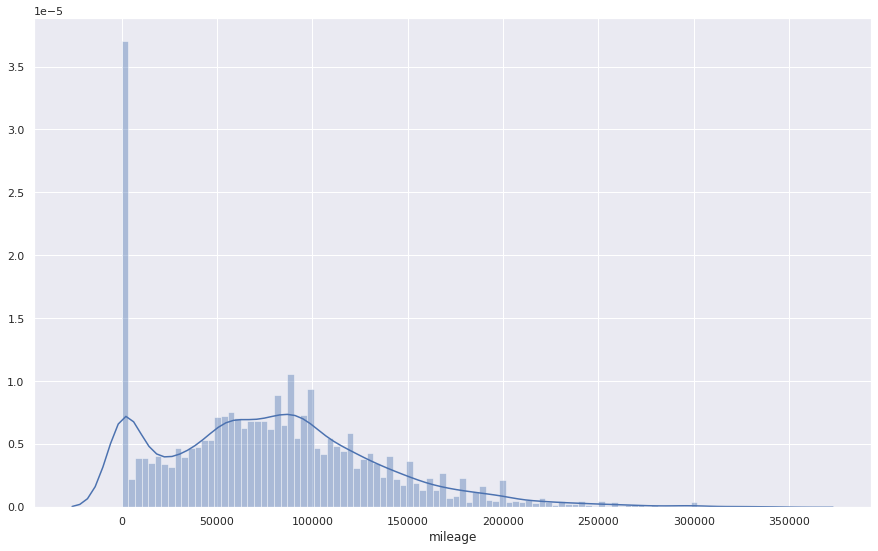

In [22]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})
#Plot de distribuição de Log(1 + Quilometragem)

sns.distplot(df['mileage'], hist=True, bins=100)

<AxesSubplot:xlabel='price'>

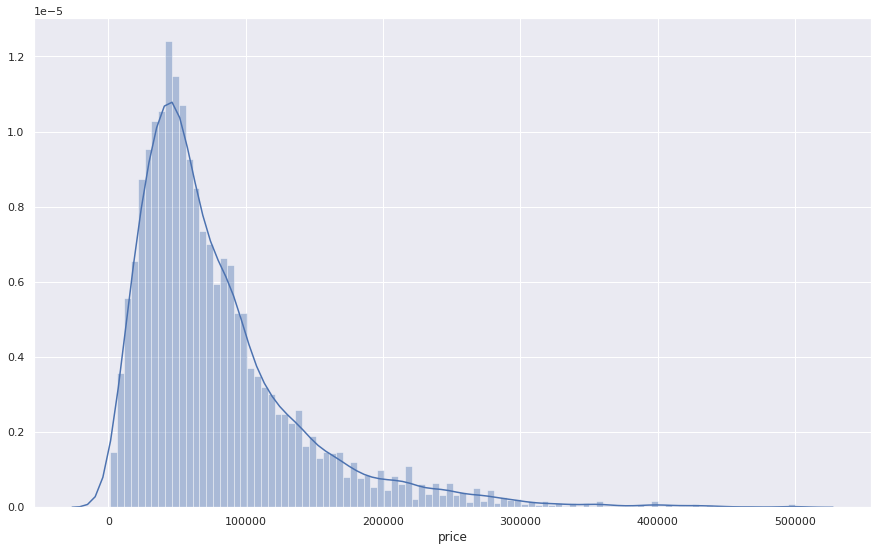

In [23]:
sns.distplot(np.minimum(df['price'], 500000), hist=True , bins=100)

In [24]:
df.isna().sum()

listId              0
sellerName          0
adDate              0
price               0
ddd                 0
brand               0
model               0
versao              0
gearbox            92
titulo              0
region              0
vehicle_model       0
cartype          1938
regdate             0
mileage             0
motorpower       1808
fuel              190
car_steering     1889
carcolor         1411
doors             610
end_tag          2068
extra            1168
addesc              0
pro_vendor          0
dtype: int64

In [25]:
df.groupby('versao').motorpower.agg(pd.Series.mode).get('RENEGADE LONG. T270 1.3 TB 4X2 FLEX AUT.', default=None)

'1.3'

In [26]:
df[['versao','regdate','motorpower']].loc[df.versao=='207 SW XR 1.4 FLEX 8V 5P']

,versao,regdate,motorpower
Id,,,
1,207 SW XR 1.4 FLEX 8V 5P,2012,1.0
2913,207 SW XR 1.4 FLEX 8V 5P,2011,1.4
10422,207 SW XR 1.4 FLEX 8V 5P,2012,1.4
13879,207 SW XR 1.4 FLEX 8V 5P,2013,1.4


In [27]:
freq_mp_by_version = df.groupby('versao').motorpower.agg(pd.Series.mode)

df.motorpower.loc[df.motorpower.isna()] = df.loc[df.motorpower.isna()].apply(lambda x: freq_mp_by_version[x.versao], axis=1)

In [28]:
df.motorpower = df.motorpower.apply(lambda x: x if isinstance(x, str) else x.any())

In [29]:
df.loc[df.motorpower.isna(), 'motorpower'] = df.brand.loc[df.motorpower.isna()].map(df.groupby('brand').motorpower.agg(pd.Series.mode))

/home/lorenzovaralo/anaconda3/envs/ML/lib/python3.7/site-packages/pandas/core/algorithms.py:944: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'bool'
  warn(f"Unable to sort modes: {err}")


In [30]:
BrandsByPriceMEAN = df.groupby('brand').price.median().sort_values().index

<AxesSubplot:xlabel='price', ylabel='brand'>

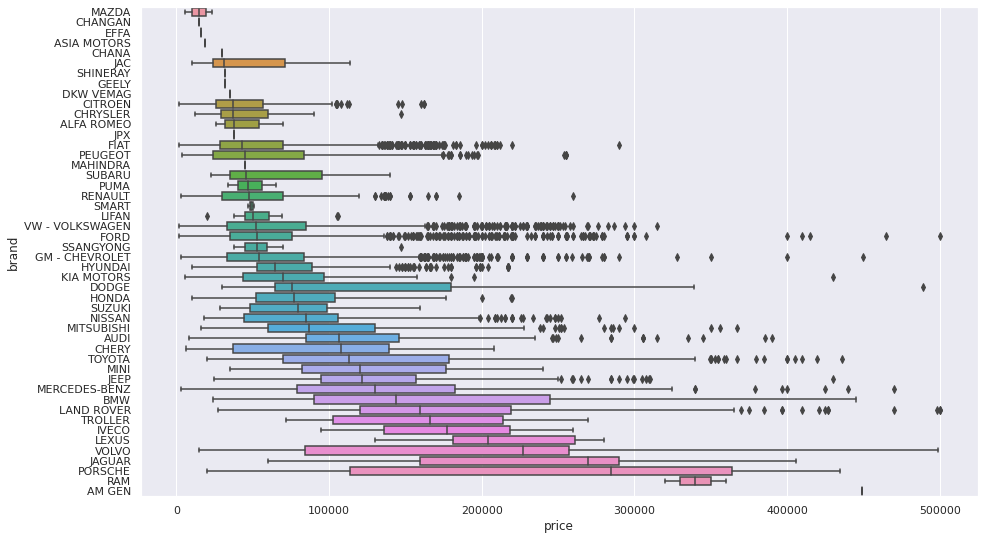

In [31]:
sns.boxplot(x='price', y='brand', data=df, order = BrandsByPriceMEAN)

In [32]:
df.titulo.loc[df.brand == 'MAZDA']

Id
23                      Mazda MX3 1.6 16v 
7341    Mazda 626 GLX 2.0 1995 Automático 
Name: titulo, dtype: object

In [33]:
df = df.loc[df.price.loc[df.price != ''].index]
df.price = np.minimum(df.price.astype(int), 500000)

In [34]:
df.describe()

,listId,price,mileage,pro_vendor
count,1.338200e+04,13382.000000,13382.000000,13382.000000
mean,1.006990e+09,79262.399043,78843.241444,0.632491
std,3.125735e+07,62130.332583,57974.323326,0.482145
min,5.126301e+08,1500.000000,0.000000,0.000000
25%,1.002125e+09,38900.000000,36000.000000,0.000000
50%,1.019959e+09,61900.000000,75000.000000,1.000000
75%,1.023539e+09,99900.000000,111111.000000,1.000000
max,1.028629e+09,499900.000000,347000.000000,1.000000


In [35]:
df = df.loc[df.price > 2000]

In [36]:
fipe.Modelo = fipe.Modelo.str.upper()

In [37]:
df.versao = df.versao.str.replace('.', '', regex=False)
fipe.Modelo = fipe.Modelo.str.replace('.','', regex=False)

In [38]:
convert_list3 = {'KA 10 SE 12V FLEX 4P MANUAL': 'KA 15 SEDAN SE 12V FLEX 4P MEC',
 'COROLLA ALTIS 20 FLEX 16V AUT': 'COROLLA ALTIS/APREMIU 20 FLEX 16V AUT',
 'UNO ATTRACTIVE 10 EVO FIRE FLEX 8V 5P': 'UNO ATTRACTIVE 10 FIRE FLEX 8V 5P',
 '320IA MODERN/SPORT TB 20/AFLEX 16V 4P': '320IA MODERN/SPORT TB 20/AFLEX/GP 4P',
 'VOYAGE COMF/HIGHLI 16 MI TFLEX 8V 4P': 'VOYAGE COMF/HIGHLI 16 TFLEX 8V 4P',
 'DUSTER DYNAMIQUE 20  HI-FLEX 16V AUT': 'DUSTER DYNAMIQUE 20 FLEX 16V AUT',
 'PALIO ATTRA/ITALIA 14 EVO FFLEX 8V 5P': 'PALIO ATTRA/ITÁLIA 14 EVO FFLEX 8V 5P',
 'FREEMONT 24 16V 5P AUT': 'FREEMONT EMOT/PRECISION 24 16V 5P AUT',
 'RANGE ROVER EVOQUE SI4 HSE DYNAMIC 20 AUT': 'RANGE REVOQUE SI4 HSE DYN 20/FLEX AUT',
 '320IA 20 TURBO/ACTIVEFLEX 16V 184CV  4P': '320IA 20 TURBO/ACTIVEFLEX 16V/GP  4P',
 'KWID 10 ZEN': 'KWID ZEN 10 FLEX 12V 5P MEC',
 'RANGE ROVER EVOQUE DYNAMIC 20 AUT 5P': 'RANGE REVOQUE DYNAMIC TECH 20 AUT 5P',
 '20 MPFI GLS 16V 143CV 2WD FLEX 4P AUT': 'TUCSON 20 16V FLEX AUT',
 '20 XEI 16V FLEX 4P AUTOMATICO': 'COROLLA XEI 20 FLEX 16V AUT',
 'SANTA FE GLS 33 V6 4X4 TIPTRONIC': 'SANTA FE/GLS 33 V6 4X4 TIPTRONIC',
 'SANDERO SPORT RS 20 HI-POWER 16V 5P': 'SANDERO SPORT RS 20 FLEX 16V 5P',
 'PALIO ELX 14 MPI FIRE FLEX 8V 4P': 'PALIO WEEKEND ELX 14 MPI FIRE FLEX 8V',
 '320IA 20 TB M SPORT ACTIVEFLEX 16V 4P': '320IA 20 TB M SPORT AFLEX/MSPORT 4P',
 'DUSTER EXPRESSION16 FLEX 16V AUT': 'DUSTER EXPRESSION 16 FLEX 16V AUT',
 'TIGGO 8 TXS 16 TURBO TGDI AUT': 'TIGGO 8 TXS 16 16V TGDI AUT',
 'SORENTO 35 V6 24V 278CV 4X4 AUT': 'SORENTO 35 V6 24V 4X4 AUT',
 'KA+ SEDAN 10 TIVCT FLEX 4P': 'KA+ SEDAN 10 SE/SE PLUS TIVCT FLEX 4P',
 'KA 15 16V FLEX 5P': 'KA SEL 15 16V FLEX 5P',
 'DUSTER DYNAMIQUE 16 HI-FLEX 16V MEC': 'DUSTER DYNAMIQUE 16 FLEX 16V MEC',
 'HATCH PREM 10 12V TB FLEX 5P AUT': 'ONIX HATCH PREM 10 12V TB FLEX 5P AUT',
 'HATCH LT 10 12V FLEX 5P MEC': 'ONIX HATCH LT 10 12V FLEX 5P MEC',
 'DUSTER OROCH DYNA 20 HI-FLEX 16V AUT': 'DUSTER OROCH DYNA 20 FLEX 16V AUT',
 'ULTRA 20 16V 4X4 DIESEL AUT': 'TORO ULTRA 20 16V 4X4 DIESEL AUT',
 'HATCH LTZ 10 12V TB FLEX 5P AUT': 'ONIX HATCH LTZ 10 12V TB FLEX 5P AUT',
 'DISCOVERY SPORT SE 20 4X4 AUT':'DISCOVERY SPORT HSE 20 4X4 AUT/ FLEX',
 'ARGO DRIVE 10 FIREFLY':'ARGO DRIVE 10 6V FLEX',
 'FIESTA PERSONNALITE 10 8V 66CV 5P':'FIESTA PERSONNALITÉ 10 8V 66CV 5P',
 'SCENIC RT/AUTH/AUTH/KIDS HI-FLEX 16 16V':'SCÉNIC RT/AUTH/AUTH/KIDS HI-FLEX 16 16V',
 '2008 GRIFE 16 TURBO FLEX 16V 5P AUT':'2008 GRIFFE 16 TURBO FLEX 16V 5P AUT',
 'TORO ENDURENCE 18 16V FLEX AUT':'TORO ENDURANCE 18 16V FLEX AUT',
 'STRADA FREEDOM 13 FLEX 8V CS PLUS':'STRADA FREEDOM 13 FLEX 8V  CS PLUS',
 'RANGE ROVER EVOQUE PURE  20 AUT 5P':'RANGE REVOQUE PURE  20 AUT 5P',
 'HATCH LT 10 12V TB FLEX 5P MEC':'ONIX HATCH LT 10 12V TB FLEX 5P MEC',
 'HB20 SENSE 10 12V FLEX MEC':'HB20 SENSE 10 FLEX 12V MEC',
 '20 MPFI GLS 16V FLEX 4P AUTOMATICO':'IX35 GLS 20 16V 2WD FLEX AUT',
 'GOL CITY 16 MI TOTAL FLEX 8V 4P':'GOL CITY (TREND) 16 MI TFLEX 8V 4P',
 'SCENIC RXE/ PRIVILÈGE 16 16V MEC':'SCÉNIC RXE/ PRIVILÈGE 16 16V MEC',
 'RANGE ROVER SPORT HSE 30 SDV6  DIESEL':'RANGE ROVER SPORT HSE 30 4X4 SDV6 DIES',
 'KA+ SEDAN 15 16V FLEX 4P':'KA+ SEDAN 15 SEL 16V FLEX 4P',
 'GLA-200 ADV 16/16 TB 16V FLEX  AUT':'GLA 200 ADVANCE 16/16 TB 16V FLEX AUT'}

In [39]:
r = np.random.randint(0, 10000)
carro = df[['versao','regdate','price']].iloc[r]
versao = carro['versao'].replace('/', '\/')
ano = carro['regdate']

fipe['Valor'].loc[(fipe.Modelo == versao)&(fipe.AnoModelo == int(ano))].values.any()


'17118'

In [40]:
lista = [fipe['CodigoFipe'].loc[fipe.Modelo == x.replace('/', '\/')].values.any() for x in df['versao'].replace(convert_list3)]
lista

['024152-0',
 '017075-5',
 '001453-2',
 '025187-9',
 '004328-1',
 '001424-9',
 '015051-7',
 '025139-9',
 '015086-0',
 '003282-4',
 '011182-1',
 '011198-8',
 '015144-0',
 '015145-9',
 '015140-8',
 '015202-1',
 '003388-0',
 '017035-6',
 '001352-8',
 '017088-7',
 '003381-2',
 '020005-0',
 '001365-0',
 '005272-8',
 '001453-2',
 '004525-0',
 '073017-3',
 '005486-0',
 '015101-7',
 False,
 '022091-4',
 '002160-1',
 '025191-7',
 '004398-2',
 '015145-9',
 '014040-6',
 '005281-7',
 '004013-4',
 '003441-0',
 False,
 '002021-4',
 '004509-8',
 '018083-1',
 '021458-2',
 '004329-0',
 '001453-2',
 '005259-0',
 '001461-3',
 '005027-0',
 '005190-0',
 '017035-6',
 '015142-4',
 '014049-0',
 '014049-0',
 '002164-4',
 '025182-8',
 '001462-1',
 '023125-8',
 '004370-2',
 '003359-6',
 '004011-8',
 '014040-6',
 '014065-1',
 '005027-0',
 '001361-7',
 '011163-5',
 '004434-2',
 '004421-0',
 '022162-7',
 '004431-8',
 '021202-4',
 '005325-2',
 '025290-5',
 '011071-0',
 '004281-1',
 '015050-9',
 '015079-7',
 '004490-

In [41]:
df['versao'].loc[list(pd.Series(lista) == False)].replace(convert_list3).value_counts().sum()

356

In [42]:
df['fipe'] = lista

In [43]:
df[['versao', 'price', 'fipe']]

,versao,price,fipe
Id,,,
1,207 SW XR 14 FLEX 8V 5P,23900,024152-0
2,COMPASS LONG TD 350 20 4X4 DIESEL AUT,212990,017075-5
3,TORO VOLCANO 20 16V 4X4 TB DIESEL AUT,137990,001453-2
4,SANDERO STEPWAY HI-FLEX 16 16V 5P AUT,37000,025187-9
5,ASTRA ADVANTAGE 20 MPFI 8V FLEXPOWER 5P,24990,004328-1
...,...,...,...
14752,ECOSPORT SE 15 12V FLEX 5P AUT,84900,003440-1
14753,SAMURAI JX CANVAS 13,48000,028001-1
14754,SLK-250 CGI 18 16V 204CV AUT,190000,021254-7


In [44]:
def valorFipe(row):
    cod = row[0]
    ano = int(row[1][:4])
    anos = np.sort(fipe.AnoModelo.loc[fipe.CodigoFipe == cod])
    if anos.size == 0:
        return None
    
    #ano = anos[np.abs(anos - ano).argmin()]
    return fipe.Valor.loc[(fipe.CodigoFipe == cod)&(fipe.AnoModelo == ano)].values.any()

In [45]:
df['valorFipe'] = df[['fipe', 'regdate']].apply(valorFipe, axis=1)

In [46]:
df['valorFipe']

Id
1         23577
2        214298
3        136474
4         38502
5         33836
          ...  
14752     78462
14753     17937
14754    182218
14755     28869
14756     38985
Name: valorFipe, Length: 13378, dtype: object

In [47]:
#remover versoes não encontradas no Fipe
df = df.loc[df.valorFipe.notna()]
df.loc[:,'valorFipe'] = df['valorFipe'].astype(int)
df = df.loc[df.valorFipe >100]

<AxesSubplot:>

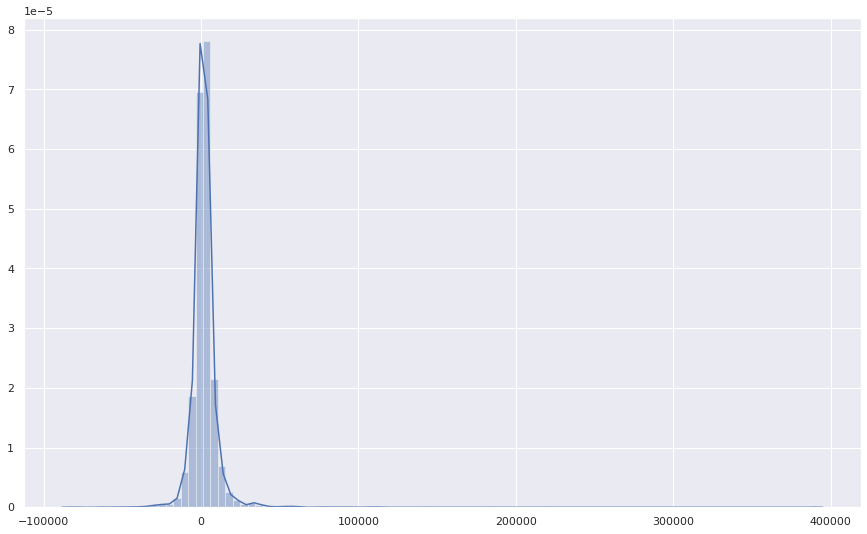

In [48]:
#Valor do Fipe comparado ao preço do anuncio
sns.distplot((df.price - df.valorFipe), bins=100)

In [49]:
df.addesc

Id
1        "CARRO EM EXCELENTE ESTADO TUDO FUNCIONANDO.&l...
2        "JEEP COMPASS LONGITUDE TD350 DIESEL!&lt;br&gt...
3        "FIAT TORO VOLCANO DIESEL 4X4 !&lt;br&gt;COMPL...
4                         "Carro em ótimo estado, 2 dono."
5        "Whatsapp - (51) 99359.1000&lt;br&gt;&lt;br&gt...
                               ...                        
14752    "Procedência, confiança e qualidade é na Pinho...
14753    "Gaiola a venda&lt;br&gt;Carroceria samurai 92...
14754    "MERCEDES SLK 250 2012, 60 MIL KM, REVISÃO FEI...
14755    "Aceito propostas por carro ano mais novo mais...
14756    "VW Up take 1.0 total flex &lt;br&gt;2014/2015...
Name: addesc, Length: 11863, dtype: object

In [50]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lorenzovaralo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
words = []

#data = df.loc[(df.price/df.valorFipe)> 1.4]
data = df.iloc[:,:]

for i in range(0,data.__len__()):
    txt = data.addesc.iloc[i]
    pattern = regex.compile(r'[^\p{L}]+', re.UNICODE)
    txt = pattern.sub(' ', txt).strip().lower()
    tokens = nltk.tokenize.word_tokenize(txt, language='portuguese')
    tokens = [x for x in tokens if x not in sw + ['br', 'gt', 'lt']]
    words.extend(tokens)
    
words = pd.Series(words)
word_list = words.value_counts().loc[words.value_counts() >10].index.to_list()
words.value_counts().loc[words.value_counts() >10]

ar             5949
carro          5604
troca          4231
direção        3952
x              3808
               ... 
inclusa          11
ilustrativa      11
zf               11
pinhais          11
all              11
Length: 3089, dtype: int64

In [52]:
rand = np.random.randint(0, 11500)

txt = df.addesc.iloc[rand]

pattern = regex.compile(r'[^\p{L}]+', re.UNICODE)

txt = pattern.sub(' ', txt).strip().lower()

tokens = nltk.tokenize.word_tokenize(txt, language='portuguese')

tokens = [x for x in tokens if x not in sw + ['br', 'gt', 'lt']]
print(rand, '\n')
print('ar' in tokens)

9137 

False


In [53]:
df.addesc.iloc[rand]

'"2003&lt;br&gt;2.0&lt;br&gt;Muito inteira!&lt;br&gt;Motor precisa retificar e está removido."'

In [54]:
(df.price / df.valorFipe).sort_values().iloc[:50:1]

Id
11841    0.101810
14084    0.216357
10785    0.233028
14685    0.237361
8295     0.238221
           ...   
14714    0.439928
5012     0.442321
7353     0.444620
9700     0.461042
10863    0.461924
Length: 50, dtype: float64

In [55]:
ind = 3575
df[['vehicle_model', 'regdate', 'price', 'valorFipe', 'pro_vendor']].loc[df.index == ind]

,vehicle_model,regdate,price,valorFipe,pro_vendor
Id,,,,,
3575,MERCEDES-BENZ CLASSE A 160 CLASSIC/ SPIRIT MEC.,2003,7500,15052,1


In [56]:
df['addesc'].loc[df.index == ind].iloc[0]

'"Mercedes Classe A 160 2003 - REPASSE - BARBADA&lt;br&gt;&lt;br&gt;&lt;br&gt;-documentação em dia, placa nova&lt;br&gt;-direção hidráulica&lt;br&gt;-ar condicionao a revisar&lt;br&gt;-vidros elétricos&lt;br&gt;-alarme&lt;br&gt;-travas elétricas&lt;br&gt;&lt;br&gt;Veículo de repasse no estado que se encontra, esta funciando, bate chave e sai andando! Documentação em dia, dut em branco, transfere na hora.&lt;br&gt;&lt;br&gt;VENDO BEM BEM ABAIXO DA FIPE QUE ESTA 15 MIL.&lt;br&gt;&lt;br&gt;Veículo com detalhes a fazer se quiser e quando puder!&lt;br&gt;&lt;br&gt;Entre em contato e saiba os detalhes&lt;br&gt;51-99133.4000&lt;br&gt;51-99395.7993&lt;br&gt;&lt;br&gt;Fins de pesquisa:&lt;br&gt;peugeot cc 307 308 206 207 208 408 3008 sw xr xrs allure griffe feline citroen c3 c4 c5 c4 pallas c4 vtr lounge picasso aircross ds3 exclusive honda new civic city fit crv corolla fielder rav4 etios hyundai azera i30 tucson santa fé sonata ix35 hb20 elantra veloster i30 sw kia sportage cadenza soul soren

In [57]:
print(df.titulo.loc[df.index == ind].iloc[0])

Mercedes Classe A 160 2003, cambio manual, documento em dia, bem baixo da fipe, Barbada 


In [58]:
df.listId.loc[df.index == ind]

Id
3575    994870044
Name: listId, dtype: int64

In [59]:
df.addesc.loc[(df.addesc.str.lower().str.find('peça')>-1)].iloc[0]

'"Raro exemplar, mecânica impecável, pegar e andar, ótimo para projeto, passeios e coleção.&lt;br&gt;&lt;br&gt;Só estou vendendo porque comprei um MX3 V6 para projeto.&lt;br&gt;&lt;br&gt;Dispenso curiosos e aceito propostas &lt;br&gt;&lt;br&gt;Carro econômico e com peças novas  amplamente disponíveis no ML ( salvo lataria )&lt;br&gt;&lt;br&gt;#Mazda #JDM #PocketRocket #gearhead"'

In [60]:
df.loc[(df.price/df.valorFipe)< 0.3]

,listId,sellerName,adDate,price,ddd,brand,model,versao,gearbox,titulo,region,vehicle_model,cartype,regdate,mileage,motorpower,fuel,car_steering,carcolor,doors,end_tag,extra,addesc,pro_vendor,fipe,valorFipe
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
8295,989427730,Dudu,1970-01-19 23:30:59,19900,51,PORSCHE,CAYENNE,CAYENNE S 45/48,Automático,PORSCHE CAYENNE | VENDER EM PEÇAS,Porto Alegre e região,PORSCHE CAYENNE S 4.5/4.8,SUV,2006,1000,4.0 ou mais,Gasolina,None,Preto,4 portas,3,None,"""Cayenne S&lt;br&gt;&lt;br&gt;Ela está sem mot...",1,035024-9,83536
8776,1023565683,Rogerio Schneider,1970-01-19 23:30:49,3000,51,VW - VOLKSWAGEN,GOL,GOL 1000 (MODELO ANTIGO),None,Troca gol 1.0 93 CHT por caiaque de pesca ou M...,Porto Alegre e região,VW - VOLKSWAGEN GOL 1000 (MODELO ANTIGO),None,1993,7777,1.0,Gasolina,None,None,2 portas,7,None,"""Troco gol 1.0 93 doc em dia dut em branco por...",0,005028-8,10510
10785,1024103895,Raila,1970-01-19 23:33:10,3000,51,VW - VOLKSWAGEN,PARATI,PARATI CLI / CL/ ATLANTA 18,Manual,Carro Parati,Porto Alegre e região,VW - VOLKSWAGEN PARATI CLI / CL/ ATLANTA 1.8,None,1992,200000,1.8,Álcool,Hidráulica,Vermelho,4 portas,4,None,"""Vendo Parati Cl ano 1992&lt;br&gt;Carro usand...",0,005049-0,12874
11841,1026018982,momoveiculos,1970-01-19 23:39:25,5490,51,FORD,ECOSPORT,ECOSPORT FREESTYLE 16 16V FLEX 5P,Manual,Ford Ecosport Freestyle 1.6 16v,Porto Alegre e região,FORD ECOSPORT FREESTYLE 1.6 16V FLEX 5P,SUV,2013,140000,1.6,Gás Natural,Elétrica,Vermelho,4 portas,None,"vidro elétrico, air bag, trava elétrica, ar co...","""Estou à venda !!!&lt;br&gt;?&lt;br&gt;Entrada...",1,003367-7,53924
14084,1027670381,gutopthomas,1970-01-19 23:45:25,12000,54,HYUNDAI,HB20X,HB20X STYLE 16 FLEX 16V MEC,Manual,Hb20x,Caxias do Sul e região,HYUNDAI HB20X STYLE 1.6 FLEX 16V MEC.,Sedã,2015,147000,1.6,Flex,Hidráulica,Branco,4 portas,6,"vidro elétrico, air bag, trava elétrica, ar co...","""HB 20 X Style ano 2015 motor 1.6 cambio mecân...",0,015094-0,55464
14685,1028579869,sadi galvao,1970-01-19 23:48:18,8000,51,RENAULT,SANDERO,SANDERO AUTHENTIQUE HI-POWER 10 16V 5P,Manual,Sucata Sandero 2015 aceito proposta .,Porto Alegre e região,RENAULT SANDERO AUTHENTIQUE HI-POWER 1.0 16V 5P,Hatch,2015,120000,1.0,Flex,Hidráulica,Branco,4 portas,7,None,"""Vende=se sucata Sandero Ano 2015 Branco .&lt...",1,025216-6,33704


In [61]:
"""words = ['carro',
'motor',
'valor',
'ok',
'vendo',
'fazer',
'hora',
'troca',
'caixa',
'fipe',
'manual',
'transfere',
'branco',
'bom',
'entrada',
'pneus',
'ótimo',
'pago',
'abaixo',
'peça',
'por moto',
'em moto',
'precis',
'docum',
'troco',
'bateria',
'porém',
'multa',
'rodar',
'acima',
'reparo',
' feito',
'parad',
'estado',
'segundo',
'barbada',
'perfeito',
'retirada',
'queim',
'sucata',
'ofertas',
'arrum',
'coisa',
'veículo',
'ruim',
'arranh',
'ipva',
'dinheiro',
'novo',
'nova',
'vista',
'rodas',
'impec',
'quero',
'manual',
'pneus',
'bancos',
'chave']"""

words = word_list

a = {}
b = {}

for w in words:
    data = df.loc[df.addesc.str.lower().str.find(w)>-1]
    a[w] = (data.price/data.valorFipe).mean() - 1.0409034276258113
    b[w] = data.__len__()
print(pd.Series(a).sort_values(ascending=False))

restaurado     1.691528
virabrequim    1.270033
chevette       1.155906
coletor        1.117881
cabeçote       0.961138
                 ...   
procuração    -0.230150
arrumar       -0.295211
prestações    -0.330240
assume        -0.333923
assumir       -0.400892
Length: 3089, dtype: float64


In [62]:
c = pd.Series(a).sort_values().copy()

In [63]:
c.loc[pd.Series(b).loc[c.index]>1]

assumir       -0.400892
assume        -0.333923
prestações    -0.330240
arrumar       -0.295211
procuração    -0.230150
                 ...   
cabeçote       0.961138
coletor        1.117881
chevette       1.155906
virabrequim    1.270033
restaurado     1.691528
Length: 3089, dtype: float64

In [64]:
c = c.loc[((c<-0.05)|(c>0.05))&(pd.Series(b).loc[c.index]>20)]
c

assume          -0.333923
desconto        -0.161210
básico          -0.148154
dívida          -0.146482
repasse         -0.136914
                   ...   
funcionamento    0.538100
opala            0.583314
antigo           0.676970
escort           0.697569
verdade          0.722377
Length: 557, dtype: float64

In [65]:
print(df.columns)
df.cartype

Index(['listId', 'sellerName', 'adDate', 'price', 'ddd', 'brand', 'model', 'versao', 'gearbox', 'titulo', 'region', 'vehicle_model', 'cartype', 'regdate', 'mileage', 'motorpower', 'fuel', 'car_steering', 'carcolor', 'doors', 'end_tag', 'extra', 'addesc', 'pro_vendor', 'fipe', 'valorFipe'], dtype='object')


Id
1               None
2                SUV
3            Pick-up
4              Hatch
5               None
            ...     
14752            SUV
14753        Passeio
14754    Conversível
14755           Sedã
14756          Hatch
Name: cartype, Length: 11863, dtype: object

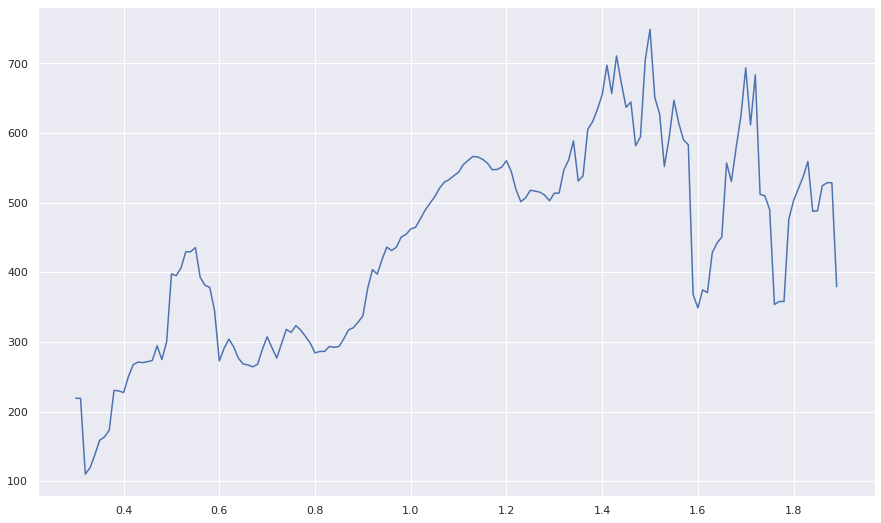

In [66]:
# Quantidade de caractéres na descrição é relacionado com o preço/fipe,
# Descrições menores = melhores ofertas , em boa parte dos casos
x = np.arange(0.3,1.9, 0.01)
relacao = (df.price/df.valorFipe)
y = np.array([])
for i in x:
    y = np.append(y, df.addesc.str.len().loc[(relacao < i)&(relacao >(i-0.1))].mean())

plt.plot(x,y)

In [67]:
mldf = df.loc[:, ['brand', 'gearbox', 'regdate', 'mileage', 'motorpower', 'fuel', 'car_steering', 'doors', 'valorFipe', 'addesc']]

In [68]:
mldf.isna().sum()

brand              0
gearbox           73
regdate            0
mileage            0
motorpower         0
fuel             159
car_steering    1606
doors            525
valorFipe          0
addesc             0
dtype: int64

In [69]:
pd.options.display.width = 0
df.vehicle_model.loc[df.gearbox.isna()]

Id
187                         SUZUKI GRAND VITARA 2.0 16V 3P
261                           FIAT UNO MILLE  ELX  2P E 4P
402      VW - VOLKSWAGEN JETTA HIGHLINE 2.0 TSI 16V 4P ...
602                 HYUNDAI HB20 PREMIUM 1.6 FLEX 16V AUT.
656      VW - VOLKSWAGEN GOL (NOVO) 1.0 MI TOTAL FLEX 8...
                               ...                        
13455                 FORD KA 1.0 SE/SE PLUS TIVCT FLEX 5P
13457          FIAT UNO MILLE 1.0 FIRE/ F.FLEX/ ECONOMY 2P
14200    VW - VOLKSWAGEN PASSAT HIGHLINE 2.0 TSI 220CV ...
14292    GM - CHEVROLET AGILE LTZ 1.4 MPFI 8V FLEXPOWER 5P
14635          FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P
Name: vehicle_model, Length: 73, dtype: object

In [70]:
auto = ['AUT','AUT.','AUTOMATICO']

for automatico in auto:
    df.loc[(df.vehicle_model.str.endswith(automatico))&(df.gearbox != 'Automático'), 'gearbox'] = 'Automático'

In [71]:
mec = ['MEC', 'MEC.']

for manual in mec:
    df.gearbox.loc[(df.vehicle_model.str.endswith(manual))&(df.gearbox != 'Manual')] = 'Manual'

/home/lorenzovaralo/anaconda3/envs/ML/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [72]:
df.vehicle_model.loc[df.vehicle_model.str.endswith('MEC')]

Id
35       GM - CHEVROLET CRUZE HB SPORT LT 1.8 16V FLEXP...
78        CITROEN C3 EXCLUS./EXCL.SOLARIS 1.6 FLEX 16V MEC
169                HYUNDAI HB20 EVOLUTION 1.0 FLEX 12V MEC
197            GM - CHEVROLET HATCH LT 1.0 12V FLEX 5P MEC
221                  HYUNDAI HB20S VISION 1.0 FLEX 12V MEC
                               ...                        
14260    GM - CHEVROLET VECTRA ELEGAN. 2.0 MPFI 8V FLEX...
14338    GM - CHEVROLET CRUZE HB SPORT LT 1.8 16V FLEXP...
14505     RENAULT DUSTER DYNAMIQUE 4X4 2.0 HI-FLEX 16V MEC
14689    GM - CHEVROLET VECTRA EXPRESSION 2.0 MPFI FLEX...
14720     CITROEN C3 PICASSO EXCLUSIVE 1.6 FLEX 16V 5P MEC
Name: vehicle_model, Length: 123, dtype: object

In [73]:
gear_by_version = df.groupby('vehicle_model')['gearbox']

gear_by_version = gear_by_version.agg(pd.Series.mode).apply(lambda x: x if isinstance(x, str) else 'Manual')

In [74]:
gear_by_version

vehicle_model
ALFA ROMEO 147 2.0 16V 148CV 4P SEMI-AUT.                   Automático
ALFA ROMEO 156 TS/SPORT/ELEGANT 2.0 16V                         Manual
ALFA ROMEO 164 3.0 V6                                           Manual
ASIA MOTORS TOPIC CARGA 2.7 DIESEL (FURGÃO)                     Manual
AUDI A1 1.4 TFSI 122CV S-TRONIC 3P                          Automático
                                                               ...    
VW - VOLKSWAGEN VOYAGE I MOTION TREND 1.6 MI T. FLEX 8V         Manual
VW - VOLKSWAGEN VOYAGE L/LS/PLUS/GLS/S/SPORT/SUPER L.ANG        Manual
VW - VOLKSWAGEN VOYAGE TREND 1.6 MI TOTAL FLEX 8V 4P            Manual
VW - VOLKSWAGEN VOYAGE TRENDLINE 1.0 T.FLEX 12V 4P              Manual
VW - VOLKSWAGEN VOYAGE TRENDLINE 1.6 T.FLEX 8V 4P               Manual
Name: gearbox, Length: 2165, dtype: object

In [75]:
df.loc[:, 'gearbox'] = df.vehicle_model.map(gear_by_version)

In [76]:
df.loc[df.gearbox.str.find('Semi-Automático')>-1, 'gearbox'] = 'Automático'

In [77]:
df.isna().sum()

listId              0
sellerName          0
adDate              0
price               0
ddd                 0
brand               0
model               0
versao              0
gearbox             0
titulo              0
region              0
vehicle_model       0
cartype          1722
regdate             0
mileage             0
motorpower          0
fuel              159
car_steering     1606
carcolor         1217
doors             525
end_tag          1834
extra             936
addesc              0
pro_vendor          0
fipe                0
valorFipe           0
dtype: int64

In [78]:
df.car_steering = df.vehicle_model.map(df.groupby('vehicle_model')['car_steering'].agg(pd.Series.mode)).apply(lambda x: x if isinstance(x, str) else x.any())

In [79]:
df.loc[df.car_steering == False, 'car_steering'] = 'Hidráulica'

In [80]:
doors_by_vm = df.groupby('vehicle_model')['doors'].agg(pd.Series.mode)
df.doors.loc[df.doors.isna()] = df.vehicle_model.loc[df.doors.isna()].map(doors_by_vm.apply(lambda x: x if isinstance(x, str) else x.any()))

/home/lorenzovaralo/anaconda3/envs/ML/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [81]:
df.loc[df.doors == False, 'doors'] = '4 portas'

In [82]:
df.doors = df.doors.apply(lambda x: 1 if x == '4 portas' else 0)

In [83]:
df.isna().sum()

listId              0
sellerName          0
adDate              0
price               0
ddd                 0
brand               0
model               0
versao              0
gearbox             0
titulo              0
region              0
vehicle_model       0
cartype          1722
regdate             0
mileage             0
motorpower          0
fuel              159
car_steering        0
carcolor         1217
doors               0
end_tag          1834
extra             936
addesc              0
pro_vendor          0
fipe                0
valorFipe           0
dtype: int64

In [84]:
for i in df.columns:
    print(f'{i} Falses=', (df.loc[:, i] == False).sum())
    print(f'{i} Nones=', (df.loc[:, i] == None).sum())

listId Falses= 0
listId Nones= 0
sellerName Falses= 0
sellerName Nones= 0
adDate Falses= 0
adDate Nones= 0
price Falses= 0
price Nones= 0
ddd Falses= 0
ddd Nones= 0
brand Falses= 0
brand Nones= 0
model Falses= 0
model Nones= 0
versao Falses= 0
versao Nones= 0
gearbox Falses= 0
gearbox Nones= 0
titulo Falses= 0
titulo Nones= 0
region Falses= 0
region Nones= 0
vehicle_model Falses= 0
vehicle_model Nones= 0
cartype Falses= 0
cartype Nones= 0
regdate Falses= 0
regdate Nones= 0
mileage Falses= 740
mileage Nones= 0
motorpower Falses= 121
motorpower Nones= 0
fuel Falses= 0
fuel Nones= 0
car_steering Falses= 0
car_steering Nones= 0
carcolor Falses= 0
carcolor Nones= 0
doors Falses= 1136
doors Nones= 0
end_tag Falses= 0
end_tag Nones= 0
extra Falses= 0
extra Nones= 0
addesc Falses= 0
addesc Nones= 0
pro_vendor Falses= 4207
pro_vendor Nones= 0
fipe Falses= 0
fipe Nones= 0
valorFipe Falses= 0
valorFipe Nones= 0


In [85]:
df.loc[df.fuel.isna(), 'fuel'] = df.loc[df.fuel.isna(), 'vehicle_model'].map(df.groupby('vehicle_model').fuel.agg(pd.Series.mode)).apply(lambda x: x if isinstance(x, str) else x.any())
df.loc[df.fuel == False, 'fuel'] = df.loc[df.fuel == False, 'brand'].map(df.groupby('brand').fuel.agg(pd.Series.mode)).apply(lambda x: x if isinstance(x, str) else x.any())

In [86]:
ind = df.loc[df.fuel.isna()].index

In [87]:
df.fuel.loc[df.index.isin(ind)].value_counts()

Series([], Name: fuel, dtype: int64)

In [88]:
df.loc[(df.vehicle_model.str.find('DIE') > -1)&(df.fuel != 'Diesel'), 'fuel'] = 'Diesel'

In [89]:
df.loc[(df.vehicle_model.str.find('FLEX') > -1)&(df.fuel != 'Flex'), 'fuel'] = 'Flex'

In [91]:
df.isna().sum()

listId              0
sellerName          0
adDate              0
price               0
ddd                 0
brand               0
model               0
versao              0
gearbox             0
titulo              0
region              0
vehicle_model       0
cartype          1722
regdate             0
mileage             0
motorpower          0
fuel                0
car_steering        0
carcolor         1217
doors               0
end_tag          1834
extra             936
addesc              0
pro_vendor          0
fipe                0
valorFipe           0
dtype: int64

In [103]:
df.loc[(df.fuel != 'Flex')&(df.fuel != 'Gasolina')&(df.fuel != 'Diesel'), 'fuel'] = 'Outro'

In [104]:
df.fuel.value_counts()

Flex        8546
Gasolina    1899
Diesel      1367
Outro         51
Name: fuel, dtype: int64

In [106]:
df

11863

In [110]:
a = pd.DataFrame([['a',1],['b',2],['c',3], [False,4]])

In [117]:
~a[0].astype(bool)

0    False
1    False
2    False
3     True
Name: 0, dtype: bool

In [ ]:
df.dropna(,)